<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals
- Explore polynomial interpolation of data
- See why only low-order polynomials are generally useful (Runge's phenomenon)
- Be able to use Legendre and CubicSpline routines

#Interpolation vs Curve-fitting

Interpolation and curve-fitting both deal with fitting lists curves to a list of distrete points but there are some key differences in terminology:

**Interpolation** seeks a curve that
* Goes through all the points in the inputs.
* Assumes there is no measurement error in data points
* No ambiguity in mapping x and y (no duplicate y's for a given x)
* Often used to capture the *local* behaviour

**Curve fitting** seeks a curve that
* is the *best fit* for all datapoints (in some sense)
* doesn't necessarily traverse all the datapoints
* permits ambiguity in x-y pairs
* Is more of a *global* encapsulation of the data.
* generally recovers interpolation as a 'perfect fit' under the interpolation criteria.  


# Interpolation

Interpolation is a more fundamental concept since it was historically *easier* to do, either direclty as a local process and/or adding new information as it was obtained.   

We need to consider a few things for interpolation:
* Speed of building the model
* Speed of adding new data to the model
* Speed of execution for interpolated values
* Generalizability to N-D

The methods discussed here rely on a fundamental property of linear algebra:
**It is always possible to construct a *unique* polynomial of degree $n$ that passes through $n + 1$ distinct data points!**

#### Example: Interpolating a Gaussian curve

For illustrative purposes, let's design a toy problem for exploration:

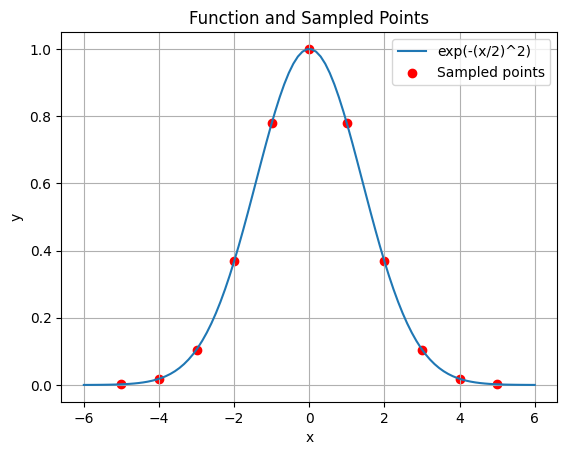

x_d: [-5 -4 -3 -2 -1  0  1  2  3  4  5]
y_d: [0.00193045 0.01831564 0.10539922 0.36787944 0.77880078 1.
 0.77880078 0.36787944 0.10539922 0.01831564 0.00193045]


In [2]:
# prompt: Plot the function exp(-(x/2)^2) from -5 to 5. Then sample 11 times at 1 intervals,  marking the points on the plot and outputting the results as x_d and y_d

import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
  return np.exp(-(x/2)**2)

# Create x values for plotting
x_toy = np.linspace(-6, 6, 100)
y_toy = f(x_toy)

# Sample 11 times at 1-interval intervals
x_d = np.arange(-5, 6, 1)
y_d = f(x_d)

# Plot the function and sampled points
plt.plot(x_toy, y_toy, label='exp(-(x/2)^2)')
plt.scatter(x_d, y_d, color='red', label='Sampled points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Function and Sampled Points')
plt.grid(True)
plt.show()

print("x_d:", x_d)
print("y_d:", y_d)


Our goal is to use the sampled data (the red points) and recover the 'true' function (in blue) as faithfully as possible.

##Lagrange Polynomial Interpolation

Legendre polynomial interpolation constructs the Legendre polynomial as,
$$
y(x) = \sum_{i = 1}^n y_i P_i(x)
$$

which is a weighted sum of the Lagrange basis polynomials, $P_i(x)$,

$$
P_i(x) = \prod_{j = 1, j\ne i}^n\frac{x - x_j}{x_i - x_j}.
$$

N.B.: $\prod$ means *the product of*, like $\sum$ means *the sum of*.

### Legendre basis polynomials

By construction,
- $P_i(x) = 1$ when $i = j$
- $P_i(x_j) = 0$ when $i \ne j$.


#### Example: Find and plot the Lagrange basis polynomials

Use the data:
*x = [0, .5, 2]*
*y = [1, 3, 2]*

\begin{eqnarray*}
P_1(x) &=& \frac{(x - x_2)(x - x_3)}{(x_1-x_2)(x_1-x_3)} = \frac{(x - 1)(x - 2)}{(0-1)(0-2)} = \frac{1}{2}(x^2 - 3x + 2),\\
P_2(x) &=& \frac{(x - x_1)(x - x_3)}{(x_2-x_1)(x_2-x_3)} = \frac{(x - 0)(x - 2)}{(1-0)(1-2)} = -x^2 + 2x,\\
P_3(x) &=& \frac{(x - x_1)(x - x_2)}{(x_3-x_1)(x_3-x_2)} = \frac{(x - 0)(x - 1)}{(2-0)(2-1)} = \frac{1}{2}(x^2 - x).
\end{eqnarray*}


Plot each polynomial and verify the property that $P_i(x_j) = 1$ when $i = j$ and $P_i(x_j) = 0$ when $i \ne j$.

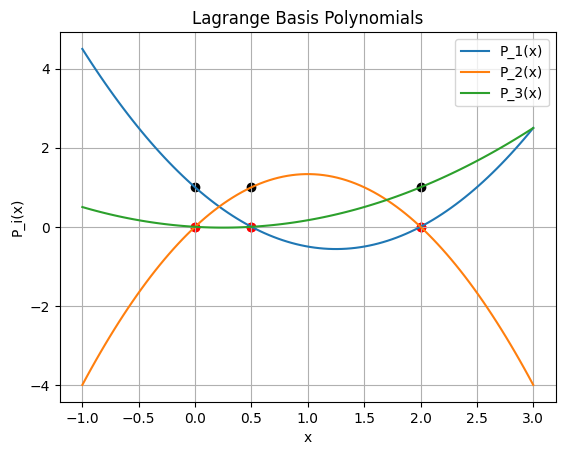

In [3]:
# prompt: show me the legendre basis polynomials for the data aove using the numpy.polynomial.legendre Legendre

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import legendre

# Data points
x = [0, .5, 2]
y = [1, 3, 2]

# Calculate the Lagrange basis polynomials
n = len(x)
P = []
for i in range(n):
  numerator = 1
  denominator = 1
  for j in range(n):
    if i != j:
      numerator = np.polymul(numerator, np.poly1d([1, -x[j]]))
      denominator = denominator * (x[i] - x[j])
  P.append(np.poly1d(np.polydiv(numerator, denominator)[0]))


# Plot the Lagrange basis polynomials
x_plot = np.linspace(-1, 3, 100)

for i in range(n):
    y_plot = P[i](x_plot)
    plt.plot(x_plot, y_plot, label=f'P_{i+1}(x)')

plt.scatter(x, [1] * len(x), color='black')
plt.scatter(x, [0] * len(x), color='red')
plt.scatter(x, [0] * len(x), color='red')

plt.xlabel('x')
plt.ylabel('P_i(x)')
plt.title('Lagrange Basis Polynomials')
plt.legend()
plt.grid(True)
plt.show()


###Assembling the polynomial

Since $P_{i\ne j}=0$, and $P_{i = j}=1$, it is trivial to see that for $ y(x) = \sum_{i = 1}^n \omega_i P_i(x) $, the coefficients are simply:

$$
y(x) = \sum_{i = 1}^n y_i P_i(x)
$$

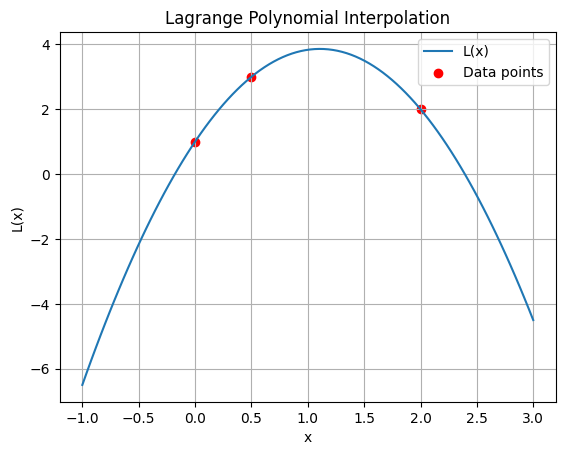

In [4]:
# prompt: Plot the legendre polynomial from the basis above

import matplotlib.pyplot as plt
import numpy as np
# Construct the Lagrange polynomial
L = np.poly1d(0)
for i in range(n):
  L = L + y[i] * P[i]

# Plot the Lagrange polynomial
y_plot = L(x_plot)
plt.plot(x_plot, y_plot, label='L(x)')
plt.scatter(x, y, color='red', label='Data points')
plt.xlabel('x')
plt.ylabel('L(x)')
plt.title('Lagrange Polynomial Interpolation')
plt.legend()
plt.grid(True)
plt.show()


###Analysis

We can observe some notes:
* For $n$ data points we necessarily produce a unique polynominal that crosses each one.
* If we have two measurements at the same input, $x_i = x_j$, $P_i =\sim \frac{1}{0}$ which is undefined *unless* $x_i=x_j$ and $y_i=y_j$ in which case the data pair is redundant and can be removed.
* Each evalulation of $P(x)$ involves $n-1$ products, and $L(x)$ is the sum of $n$ bases, therefore evaluation is $O(n^2)$
* Adding new data means restarting the compuation.




In [5]:
# prompt: Use sympy to fit a lagrange polynomial to the data above (with some extra points)

import sympy as sp

x = [0, 1, 2, 3, 4]
y = [1, 3, 2, 5, 7]

n = len(x)
x_sym = sp.Symbol('x')

L = 0
for i in range(n):
    term = y[i]
    for j in range(n):
        if i != j:
            term *= (x_sym - x[j]) / (x[i] - x[j])
    L += term


print(L)

print('which is an ugly way of writing out:')
print(L.simplify())


3*x*(4/3 - x/3)*(3/2 - x/2)*(2 - x) + x*(2 - x/2)*(3 - x)*(x - 1) + 5*x*(4 - x)*(x/2 - 1/2)*(x - 2)/3 + 7*x*(x/3 - 1/3)*(x/2 - 1)*(x - 3)/4 + (1 - x)*(1 - x/2)*(1 - x/3)*(1 - x/4)
which is an ugly way of writing out:
-x**4/2 + 25*x**3/6 - 21*x**2/2 + 53*x/6 + 1


###Error

It can be shown that the error in the interpolation is,

$$
y^{true}(x)-y(x) = \frac{[x-x_1][x-x_2][x-x_3]...[x-x_n]}{(n+1)!} f^{(n+1)}(\xi)
$$

where $\xi$ is in the interval $(x_0, x_n)$.

Since for $n$ datapoints there is a unique polynomial of degree $n-1$, which can be expressed as a Lagrange polynomial, **this analysis is universal to all polynomial interpolations!**. The main takeaway is that:

*The further a data point is from $x$, the more it contributes to the error.*

#Barycentric Lagrange Interpolation

Let's try to improve the performance of Lagrange Interpolation. Let:

$
\Omega(x) = \prod_{j = 1}^n [x - x_j]
$

and the *barycentric weights*, $w_i$:

$$
w_i = \prod_{j = 1, j\ne i}^n\frac{1}{x_i - x_j}.
$$

and write:

$$
P_i(x) = \Omega(x) \frac{w_i}{x - x_j}.
$$

and factor the $\Omega$ out of the sum:

$$
y(x) = \Omega(x) \sum_{j = 1}^n \frac{w_i}{x - x_j} y_i.
$$

which is $O(n)$ for evaluation. Calculation of $w_i$ can be formulated recursively, such that each $w_i$ takes $O(n)$ and the full takes $O(n^2)$ with updates n.

NB: The weights depend only on $x_i$, not $y_i$ - this means if we are measuring multiple functions on the same spacing, we can reuse the weights, leading to substantial computaitonal savings.







The benefit being that the calucation of the $\omega_i$, $O(n^2)$ is precomputed.

##Barycentric formula

We can write one more form which is commonly implemented. Let's add one more piece of data:

$$ 1 = \sum_{j=0}^n P_j = \Omega(x) \sum_{j=0}^n \frac{w_j}{x-x_j}$$

then we divide the previous function and write:

$$
f(x) = \frac{\sum_{j = 0}^n \frac{w_i}{x - x_j} y_i}{\sum_{j = 0}^n \frac{w_i}{x - x_j}}
$$

where we have cancelled $\Omega$! Besides elegance, his avoids an issue when evaluating $x\rightarrow x_i$ where roundoff can cause subtractive cancellation. Since the term appears in the numerator and denominator this cancels out!

# Newton's polynomial

Newton's polynomial interpolation has the form:

$$ f(x) = a_0 + a_1[x-x_0] + a_2 [x-x_0][x-x_1] + \dots + a_n[x-x_0][x-x_1]\dots[x-x_n]$$

which has the advantage of $O(n)$ evaluations due to recursion and nested multiplication. E.g. for 4 terms,

$$ f(x) = a_0 + [x-x_0] \bigg[a_1  + [x-x_1] \big[a_2  + [x-x_2] a_3 \big] \bigg] $$




Newton's method is also known as the **divided differences**

> This was the algorithm was used to calculate function tables like logarithms and trignometry functions. It was then the basis for the *difference engine*, an early mechanical calculator.

Let's pick a data point to start at. Say $y(x_0) = a_0 = y_0$,
$$a_0 = y_0$$

Add the next data point: $y(x_1) = a_0 + a_1(x_1-x_0) = y_1$, or:

$$a_1 = \frac{y_1 - y_0}{x_1 - x_0}$$

Now, insert data point $(x_2, y_2)$,

$$a_2 = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0}$$

and similarly,

$$a_3 = \frac{\frac{\frac{y_3-y_2}{x_3-x_2} - \frac{y_2 - y_1}{x_2-x_1}}{x_3 - x_1} - \frac{\frac{y_2-y_1}{x_2-x_1}-\frac{y_1 - y_0}{x_1 - x_0}}{x_2-x_0}}{x_3 - x_0}$$

Notice the recurrsion and the division of the differences.

Let's generalize this. Define the two-argument function:

$$ y[x_1, x_0] = \frac{y_1 - y_0}{x_1 - x_0}$$

and the ternary recursively:

$$ y[x_2, x_1, x_0] = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0} = \frac{y[x_2,x_1] - y[x_1,x_0]}{x_2-x_1}$$

The $n-nary$ function is:

$$ y[x_k, x_{k-1}, \dots, x_{1}, x_0] = \frac{y[x_k, x_{k-1}, \dots, x_{2}, x_2] - y[x_{k-1}, x_{k-2}, \dots, x_{1}, x_0]}{x_k-x_0}$$

We can visualize this is in a *tableau*:
$$
\begin{array}{cccccc}
x_0 & y_0 \\
    &     & y[x_1,x_0] \\
x_1 & y_1 &             & y[x_2, x_1,x_0]\\
    &     & y[x_2,x_1]  &              & y[x_3, x_2, x_1,x_0]\\
x_2 & y_2 &             & y[x_3, x_2,x_1] &             & y[x_4, x_3, x_2, x_1,x_0]\\
    &     & y[x_3,x_2]  &              & y[x_4, x_3, x_2, x_1]\\
x_3 & y_3 &             & y[x_4, x_3,x_2]\\
    &     & y[x_4,x_3] \\
x_4 & y_4
\end{array}
$$

where element is the difference of the two to the left.
Alternately, it is sometimes written in the form,  

$$
\begin{array}{c||cccccc}
x_0 & y_0 & 0 & 0 & 0 & 0\\
x_1 & y_1 & y[x_1,x_0] & 0 & 0 & 0\\
x_2 & y_2 & y[x_2,x_1] & y[x_2, x_1,x_0] & 0          & 0 \\
x_3 & y_3 & y[x_3,x_2] & y[x_3, x_2,x_1] & y[x_3, x_2, x_1,x_0] & 0            \\
x_4 & y_4 & y[x_4,x_3] & y[x_4, x_3,x_2] & y[x_4, x_3, x_2, x_1]  & y[x_4, x_3, x_2, x_1,x_0]  
\end{array}
$$

Note that the diagonal is the coefficients that we need, i.e. $a_0, a_1, a_2, a_3, a_4$ for the polynomial.

##Analysis

* The order that the datapoints are added is arbitrary but will result in a different tableau (with the same diagonal).
* We can build this matrix / tableau diagonal-by-diagonal which means adding new data points doesn't require recalculation of the others.
* Each new diagonal (datapoint) takes $O(n)$ so assembly of the tableau takes $~O(n^2)$.
* Evaluation of f(x) takes $O(n)$
* These coefficients are independant of $x$


#Example: Interpolate our toy problem

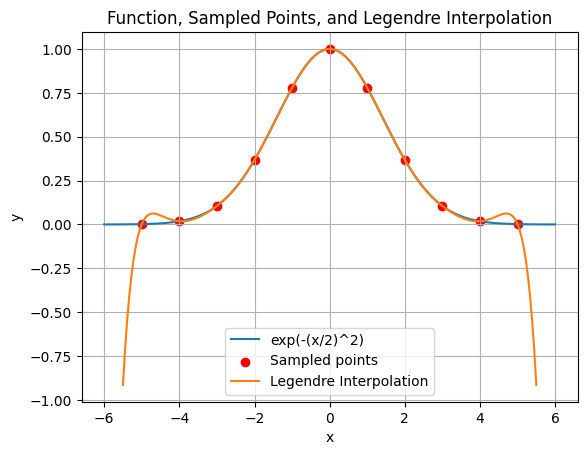

In [7]:
# prompt: Interpolate the data in x_d and y_d using numpy Legendre, and plot along with the original curve from -5.5 to 5.5

import matplotlib.pyplot as plt
import numpy as np
# Interpolate using numpy Legendre
coefficients = legendre.legfit(x_d, y_d, len(x_d) - 1)
legendre_polynomial = legendre.Legendre(coefficients)

# Create x values for plotting the interpolated polynomial
x_interp = np.linspace(-5.5, 5.5, 200)
y_interp = legendre_polynomial(x_interp)


# Plot the original curve, sampled points, and interpolated polynomial
plt.plot(x_toy, y_toy, label='exp(-(x/2)^2)')
plt.scatter(x_d, y_d, color='red', label='Sampled points')
plt.plot(x_interp, y_interp, label='Legendre Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Function, Sampled Points, and Legendre Interpolation')
plt.grid(True)
plt.show()


YIKES!

This is an example of *Runge's phenomenon*: That even for a seeminlgly ideal case of equalspaced samples, higher order polynomials can show huge oscillations between samples!

# Cubic splines



Splines were formulated to relieve these oscillations by piecing together a series of lower-order polynomials and requiring *smoothness*. Consider a polynomial over the interval between $x_i$ and $x_{i+1}$, and assert:
* $y(x_i) = y_i$
* $y(x_{i+1}) = y_{i+1}$
* $y'(x_i)$ be continuous
* $y''(x_i)$ be continuous

with these 4 constraints, it is clear we are looking for cubic functions, and therefore these splines are *piecewise cubic curves*.

We will be describing the splines in terms of the *knots*, $k_i$ which parameterize the curves. For these splines, these knots are the second derivatives at a point $x_i$.

To find the coefficients of the cubic splines, consider that the second derivative is linear and represent it with a 2-point Lagrange interpolation:
\begin{align}
y''_{i, i+1} &= k_i P_i(x) + k_{i+1} P_{i+1}(x) \\
&= \frac{k_i [x-x_{i+1}] + k_{i+1} [x-x_i]}{x_i-x_{i+1}}
\end{align}

Using the constraints above we end up with:

$$k_{i-1}[x_{i-1}-x_i]  + 2 k_i [x_{i-1} - x_{i+1}] + k_{i+1}[x_i-x_{i+1}] = 6\left[ \frac{y_{i-1}-y_i}{x_{i-1}-x_i} - \frac{y_{i}-y_{i+1}}{x_{i}-x_{i+1}} \right]$$

which is a tridiagonal matrix!

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 4 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 4 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 4 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 4 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 4 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 4 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 4 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 4 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 4 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
k_1 \\
k_2\\
k_3\\
k_4\\
k_5\\
k_6\\
k_7\\
k_8\\
k_9\\
k_{10}\\
k_{11}
\end{bmatrix}
=
\begin{bmatrix}
0\\
-0.424 \\
-1.052 \\
-0.891 \\
1.138 \\
2.654 \\
1.138 \\
-0.891 \\
-1.052 \\
-0.424 \\
0
\end{bmatrix}
$$


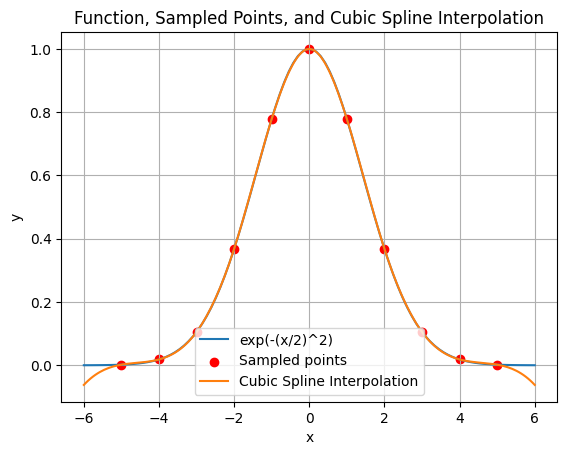

In [10]:
# prompt: Do a cubic spline of x_d and y_d and plot against the original function from -5.5 to 5.5

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Create a cubic spline interpolation
cs = CubicSpline(x_d, y_d)

# Create x values for plotting the interpolated spline
x_interp = np.linspace(-6, 6, 200)
y_interp = cs(x_interp)

# Plot the original curve, sampled points, and interpolated spline
plt.plot(x_toy, y_toy, label='exp(-(x/2)^2)')
plt.scatter(x_d, y_d, color='red', label='Sampled points')
plt.plot(x_interp, y_interp, label='Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Function, Sampled Points, and Cubic Spline Interpolation')
plt.grid(True)
plt.show()


##Analysis of cubic splines


We note:
* Cubic splines are *stiffer* in that they don't have high-frequency oscillations (thus avoiding Runge's phenomenon).
* The concept of *smoothness* is easy in 1D, but what does it mean for 2D+? How would you ensure continuity along an edge?
* Specifying *smoothness* as part of the goals going in suggest this is more of a global scheme. This requires simultaneous linears systems to be solved.


#Generalization to N-dimensions

Let's recap and generalize:
* For any $n$ points there is a polynomial that fits it, but because of Runge's phenomenon you don't want to use that!
* Piecewise polynomials are *stiffer* and avoids Runge's phenomenon, but smoothness causes issues for N-D

So what do we do? Standard pacakges offer simplistic but pragmatic interpolators (optimized for either rectangular or irregular grids) :
* Nearest ND interpolator: Find the nearest data point and use that.
* Linear ND interpolators: For each input, a triangulation finds the nearest data points and a linear barycentric Lagrange interpolation is performed.

Neither of these are completely satisfactory, so we will have to respost to more advanced methods.
